# Accessing data later, after the measurement

From *APS Python Training for Bluesky Data Acquisition*.

**Objective**

Get the data from previous *run(s)* and work with it.

## Skip the `instrument` package

There is no need to import the instrument package since we won't measure anything in this notebook.

## Access the database

In the instrument package (in file `instrument/framework/initialize.py`), we connected databroker with the MongoDB server using the `class_2021_03` *catalog*. Get that catalog now.  We'll need to import some tools first.

In [1]:
from apstools.utils import listruns, quantify_md_key_use
import databroker
from databroker.queries import TimeRange

db = databroker.catalog["training"]
listruns()

catalog: training


,scan_id,time,plan_name,detectors
0,4,2021-08-19 14:03:33,scan,[vsc16]
1,3,2021-08-19 14:03:10,scan,[vsc16]
2,2,2021-08-19 14:02:58,scan,[vsc16]
3,1,2021-08-19 14:02:41,scan,[vsc16]
4,39,2021-08-19 13:39:12,scan,[noisy]
5,38,2021-08-19 11:45:29,scan,[scaler1]
6,37,2021-08-19 11:40:40,scan,[noisy]
7,36,2021-08-19 11:39:38,scan,[noisy]
8,4,2021-08-19 11:04:45,scan,[vsc16]
9,3,2021-08-19 11:04:08,scan,[vsc16]


Our temperature count measurement is one of those listed, but which one?  Recall how we started our run: `RE(bp.count([temperature], num=50, delay=0.1, md={"motive": "tscan"}))`.  

In case some other type of run is more recent, we'll search for the most recent run with this metadata.  First, find any recent (since Feb 2021) runs with this metadata.  We need to do this search with the `v2` version of databroker catalogs.  The result of the search is another catalog.

In [2]:
cat = db.v2.search(TimeRange(since="2021-02-02")).search({"motive": "tscan"})
print(f"Search for runs with motive='tscan' metadata found {len(cat)} run(s).")

Search for runs with motive='tscan' metadata found 5 run(s).


Show the run's metadata.

In [3]:
if len(cat):
    run = cat[-1]
else:
    raise KeyError("No runs found with `motive='tscan'`")

run.metadata

{'start': Start({'beamline_id': 'APS EPICS/Python/Bluesky training VM',
 'detectors': ['temperature'],
 'hints': {'dimensions': [[['time'], 'primary']]},
 'instrument_name': 'training',
 'login_id': 'apsu@apsu-sim',
 'motive': 'tscan',
 'notebook': 'watch_temperature',
 'num_intervals': 49,
 'num_points': 50,
 'pid': 3432,
 'plan_args': {'detectors': ["MyPvPositioner(prefix='gp:userCalc8', "
                             "name='temperature', settle_time=0.0, "
                             "timeout=None, read_attrs=['setpoint', "
                             "'readback'], configuration_attrs=['calculation', "
                             "'description', 'max_change', 'noise', "
                             "'previous_value_pv', 'scanning_rate', "
                             "'tolerance'], limits=(-20, 255), egu='C')"],
               'num': 50},
 'plan_name': 'count',
 'plan_type': 'generator',
 'proposal_id': 'training-2021-04',
 'scan_id': 35,
 'time': 1618334355.5878208,
 'uid': 'c0b

## Read the primary data stream of the run

In [4]:
dataset = run.primary.read()

In [5]:
dataset

<xarray.Dataset>
Dimensions:               (time: 50)
Coordinates:
  * time                  (time) float64 1.618e+09 1.618e+09 ... 1.618e+09
Data variables:
    temperature_setpoint  (time) float64 35.0 35.0 35.0 35.0 ... 35.0 35.0 35.0
    temperature           (time) float64 34.89 35.01 35.19 ... 35.02 34.62 35.38

Let's get the values as a 1-D numpy array.

In [6]:
T = dataset["temperature"].values

## Compute the statistics
Use the methods of numpy arrays to compute maximum, mean, standard deviation, and minimum.  Looks nicer in a table.

In [7]:
import pyRestTable

table = pyRestTable.Table()
table.addLabel("measure")
table.addLabel("value")
table.addRow(("max", T.max()))
table.addRow(("mean", T.mean()))
table.addRow(("dev", T.std()))
table.addRow(("min", T.min()))
table.addRow(("#", len(T)))
print(table)

======= ===================
measure value              
======= ===================
max     35.48713664454108  
mean    34.98192172121767  
dev     0.28183495874527975
min     34.50566109712368  
#       50                 
======= ===================



Let's replot that data for comparison.

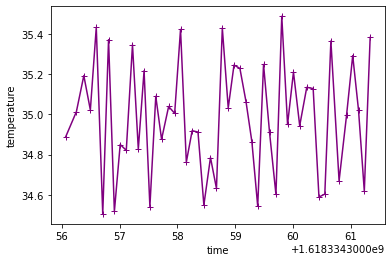

In [8]:
dataset["temperature"].plot(marker="+", color="purple")